In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 4.9 MB/s 
     |████████████████████████████████| 182 kB 59.2 MB/s 
     |████████████████████████████████| 7.6 MB 55.6 MB/s 


In [2]:
import torch

from torch.utils.data import (TensorDataset, DataLoader,
                              RandomSampler, SequentialSampler)

from transformers import BertTokenizer, BertConfig, RobertaTokenizerFast
from transformers import BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup

from distutils.version import LooseVersion as LV

from sklearn.model_selection import train_test_split

import io

import pandas as pd
import numpy as np

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    devicename = '['+torch.cuda.get_device_name(0)+']'
else:
    device = torch.device('cpu')
    devicename = ""
    
print('Using PyTorch version:', torch.__version__,
      'Device:', device, devicename)
assert(LV(torch.__version__) >= LV("1.0.0"))

Using PyTorch version: 1.12.1+cu113 Device: cuda [Tesla T4]


#Loading the multilingual dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
df_ml = pd.read_csv('/content/drive/MyDrive/Progetto_TA_2022/df_tot.csv')

In [6]:
df_ml.shape

(290183, 5)

In [7]:
df_ml.head()

,Artist,Song,Genre,Language,Lyrics
0,12 stones,world so cold,Rock,en,"It starts with pain, followed by hate\nFueled ..."
1,12 stones,broken,Rock,en,Freedom!\nAlone again again alone\nPatiently w...
2,12 stones,3 leaf loser,Rock,en,"Biting the hand that feeds you, lying to the v..."
3,12 stones,anthem for the underdog,Rock,en,You say you know just who I am\nBut you can't ...
4,12 stones,adrenaline,Rock,en,My heart is beating faster can't control these...


In [8]:
df_ml['Genre'].value_counts() #Genre distribution in training set

Rock          121404
Pop           108714
Metal          20291
Jazz           13545
Folk            8644
Indie           8449
R&B             2793
Hip-Hop         2240
Electronic      2213
Country         1890
Name: Genre, dtype: int64

Data Cleaning

In [9]:
df_ml['Genre'].isnull().values.any() #Checking the Genre column on having all valid records

False

In [10]:
df_ml['Language'].isnull().values.any()

True

In [11]:
df_ml['Lyrics'].isnull().values.any()

True

In [12]:
df_ml.dropna(subset = ['Language'], inplace=True) #eliminating the rows with NaN values in Language and Lyrics 


In [13]:
df_ml.dropna(subset = ['Lyrics'], inplace=True)

In [14]:
df_ml = df_ml.reset_index()
df_ml = df_ml.drop(['index'], axis = 1)

In [15]:
df_ml.shape

(290144, 5)

In [16]:
df_ml = df_ml.reset_index()
df_ml = df_ml.drop(['index'], axis = 1)

#Splitting the dataset in training set and test set

In [17]:
import sklearn
from sklearn.model_selection import train_test_split

In [18]:
ml_train, ml_test = sklearn.model_selection.train_test_split(df_ml, test_size=0.20, train_size=0.80)

In [19]:
ml_train.shape, ml_test.shape

((232115, 5), (58029, 5))

In [20]:
x_train = ml_train['Lyrics']
y_train = ml_train['Genre']

x_test = ml_test['Lyrics']
y_test = ml_test['Genre']

#Generating numerical labels

In [21]:
import numpy as np

label_map = {label:idx for idx,label in enumerate(sorted(set(y_train)))}
print(label_map)

y_train_vect = np.asarray([label_map[label] for label in y_train])
y_test_vect = np.asarray([label_map[label] for label in y_test])

y_train_vect,y_test_vect

{'Country': 0, 'Electronic': 1, 'Folk': 2, 'Hip-Hop': 3, 'Indie': 4, 'Jazz': 5, 'Metal': 6, 'Pop': 7, 'R&B': 8, 'Rock': 9}


(array([7, 9, 9, ..., 9, 7, 7]), array([9, 9, 0, ..., 7, 9, 7]))

#Text Pre-processing 

In [22]:
sentences_train = ["[CLS] " + s for s in x_train]
sentences_test = ["[CLS] " + s for s in x_test]
labels_train = y_train_vect
labels_test  = y_test_vect

In [23]:
from transformers import BertModel
BERTMODEL = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(BERTMODEL)
model = BertModel.from_pretrained(BERTMODEL)

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
from tqdm import tqdm

tokenized_train = [tokenizer.tokenize(s) for s in tqdm(sentences_train)]
tokenized_test  = [tokenizer.tokenize(s) for s in tqdm(sentences_test)]

100%|██████████| 58029/58029 [03:17<00:00, 293.53it/s]


In [25]:
MAX_LEN_TRAIN, MAX_LEN_TEST = 128, 512

tokenized_train = [t[:(MAX_LEN_TRAIN-1)]+['SEP'] for t in tokenized_train]
tokenized_test  = [t[:(MAX_LEN_TEST-1)]+['SEP'] for t in tokenized_test]

print ("The truncated tokenized first training sentence:")
print (tokenized_train[0])

The truncated tokenized first training sentence:
['[CLS]', 'I', "'", 'm', 'a', 'self', 'made', 'man', 'Self', 'made', 'man', 'I', "'", 'm', 'a', 'self', 'made', 'man', 'Self', 'made', 'man', 'I', "'", 'm', 'a', 'self', 'made', 'man', 'Self', 'made', 'man', 'I', "'", 'm', 'a', 'self', 'made', 'man', 'Self', 'made', 'man', 'Do', 'you', 'make', 'money', 'moth', '##af', '##uck', '##a', 'I', "'", 'm', 'the', 'mas', '##cot', 'baby', 'In', 'the', 'city', 'in', 'the', 'c', '##rib', 'of', 'the', 'Ca', '##sp', '##in', ',', 'Christmas', 'Count', 'the', 'city', 'that', 'with', 'the', 'cash', 'by', 'Billy', 'and', 'I', 'ai', '##n', "'", 't', 'go', '##n', 'stop', 'no', 'ni', '##gga', 'I', "'", 'm', 'a', 'self', 'made', 'man', 'Self', 'made', 'man', 'I', "'", 'm', 'a', 'self', 'made', 'man', 'Self', 'made', 'man', 'I', "'", 'm', 'a', 'self', 'made', 'man', 'Self', 'made', 'man', 'I', "'", 'm', 'a', 'self', 'made', 'SEP']


In [26]:
ids_train = [tokenizer.convert_tokens_to_ids(t) for t in tokenized_train]
ids_train = np.array([np.pad(i, (0, MAX_LEN_TRAIN-len(i)),
                             mode='constant') for i in ids_train])

ids_test = [tokenizer.convert_tokens_to_ids(t) for t in tokenized_test]
ids_test = np.array([np.pad(i, (0, MAX_LEN_TEST-len(i)),
                            mode='constant') for i in ids_test])

print ("The indices of the first training sentence:")
print (ids_train[0])

The indices of the first training sentence:
[  101   146   112   181   169 16567 11019 10817 34039 11019 10817   146
   112   181   169 16567 11019 10817 34039 11019 10817   146   112   181
   169 16567 11019 10817 34039 11019 10817   146   112   181   169 16567
 11019 10817 34039 11019 10817 11791 13028 13086 17920 28877 19402 31746
 10113   146   112   181 10105 11856 41746 40138 10167 10105 11584 10106
 10105   171 47116 10108 10105 26037 54609 10245   117 17265 32000 10105
 11584 10189 10169 10105 52828 10155 15894 10111   146 11346 10115   112
   188 11783 10115 20517 10192 10414 38541   146   112   181   169 16567
 11019 10817 34039 11019 10817   146   112   181   169 16567 11019 10817
 34039 11019 10817   146   112   181   169 16567 11019 10817 34039 11019
 10817   146   112   181   169 16567 11019   100]


In [27]:
amasks_train, amasks_test = [], []

for seq in ids_train:
  seq_mask = [float(i>0) for i in seq]
  amasks_train.append(seq_mask)

for seq in ids_test:
  seq_mask = [float(i>0) for i in seq]
  amasks_test.append(seq_mask)

In [28]:
(train_inputs, validation_inputs,
 train_labels, validation_labels) = train_test_split(ids_train, labels_train,
                                                     random_state=42, test_size=0.1)
 

(train_masks, validation_masks,
 _, _) = train_test_split(amasks_train, ids_train,
                          random_state=42, test_size=0.1)

train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks  = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks  = torch.tensor(validation_masks)
test_inputs = torch.tensor(ids_test)
test_labels = torch.tensor(labels_test)
test_masks  = torch.tensor(amasks_test)

In [29]:
BATCH_SIZE = 32

print('Datasets:')
print('Train: ', end="")
train_data = TensorDataset(train_inputs, train_masks,
                           train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler,
                              batch_size=BATCH_SIZE)
print(len(train_data), 'documents')

print('Validation: ', end="")
validation_data = TensorDataset(validation_inputs, validation_masks,
                                validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,
                                   sampler=validation_sampler,
                                   batch_size=BATCH_SIZE)
print(len(validation_data), 'documents')

print('Test: ', end="")
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler,
                             batch_size=BATCH_SIZE)
print(len(test_data), 'documents')

Datasets:
Train: 208903 documents
Validation: 23212 documents
Test: 58029 documents


#BERT model initialization

---



---



In [30]:
model = BertForSequenceClassification.from_pretrained(BERTMODEL,
                                                      num_labels=len(label_map))
model.cuda()
print('Pretrained BERT model "{}" loaded'.format(BERTMODEL))

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

Pretrained BERT model "bert-base-multilingual-cased" loaded


In [31]:
#We set the remaining hyperparameters needed for fine-tuning the pretrained model:
#EPOCHS: the number of training epochs in fine-tuning (recommended values between 2 and 4)
#WEIGHT_DECAY: weight decay for the Adam optimizer
#LR: learning rate for the Adam optimizer (2e-5 to 5e-5 recommended)
#WARMUP_STEPS: number of warmup steps to (linearly) reach the set learning rate
#We also need to grab the training parameters from the pretrained model.

In [32]:
EPOCHS = 3
WEIGHT_DECAY = 0.01
LR = 2e-5
WARMUP_STEPS =int(0.2*len(train_dataloader))

no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters()
                if not any(nd in n for nd in no_decay)],
     'weight_decay': WEIGHT_DECAY},
    {'params': [p for n, p in model.named_parameters()
                if any(nd in n for nd in no_decay)],
     'weight_decay': 0.0}
]
optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=LR, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=WARMUP_STEPS,
                                 num_training_steps =len(train_dataloader)*EPOCHS)

#Training
Definitions of functions to train and evaluate the model

In [33]:
def train(epoch, loss_vector=None, log_interval=200):
  # Set model to training mode
  model.train()

  # Loop over each batch from the training set
  for step, batch in enumerate(train_dataloader):

    # Copy data to GPU if needed
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Zero gradient buffers
    optimizer.zero_grad()

    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None,
                    attention_mask=b_input_mask, labels=b_labels)

    loss = outputs[0]
    if loss_vector is not None:
        loss_vector.append(loss.item())

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()
    scheduler.step()

    if step % log_interval == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, step * len(b_input_ids),
                len(train_dataloader.dataset),
                100. * step / len(train_dataloader), loss))

from sklearn.metrics import confusion_matrix, classification_report

def evaluate(loader):
  model.eval()

  n_correct, n_all = 0, 0

  predicted_labels = list()
  true_labels = list()

  for batch in loader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)
      logits = outputs[0]

    logits = logits.detach().cpu().numpy()
    predictions = np.argmax(logits, axis=1)

    labels = b_labels.to('cpu').numpy()
    n_correct += np.sum(predictions == labels)

    true_labels.extend(labels)
    predicted_labels.extend(predictions)
    n_all += len(labels)

  print('Accuracy: [{}/{}] {:.4f}'.format(n_correct, n_all,
                                          n_correct/n_all))
  print('Classification report:')
  print(classification_report(true_labels, predicted_labels,target_names=[x[0] for x in sorted(label_map.items(),key=lambda x:x[1])]))
  print('Confusion matrix:')
  cm = confusion_matrix(true_labels, predicted_labels)
  print(cm)

In [34]:
train_lossv = []
for epoch in range(1, EPOCHS + 1):
    print()
    train(epoch, train_lossv)
    print('\nValidation set:')
    evaluate(validation_dataloader)


Train Epoch: 1 [0/208903 (0%)]	Loss: 2.249213
Train Epoch: 1 [6400/208903 (3%)]	Loss: 1.487171
Train Epoch: 1 [12800/208903 (6%)]	Loss: 1.297109
Train Epoch: 1 [19200/208903 (9%)]	Loss: 1.813718
Train Epoch: 1 [25600/208903 (12%)]	Loss: 1.271112
Train Epoch: 1 [32000/208903 (15%)]	Loss: 1.194296
Train Epoch: 1 [38400/208903 (18%)]	Loss: 1.146834
Train Epoch: 1 [44800/208903 (21%)]	Loss: 1.397285
Train Epoch: 1 [51200/208903 (25%)]	Loss: 1.185787
Train Epoch: 1 [57600/208903 (28%)]	Loss: 1.154129
Train Epoch: 1 [64000/208903 (31%)]	Loss: 1.278935
Train Epoch: 1 [70400/208903 (34%)]	Loss: 0.961819
Train Epoch: 1 [76800/208903 (37%)]	Loss: 1.323961
Train Epoch: 1 [83200/208903 (40%)]	Loss: 1.270036
Train Epoch: 1 [89600/208903 (43%)]	Loss: 1.203306
Train Epoch: 1 [96000/208903 (46%)]	Loss: 1.060639
Train Epoch: 1 [102400/208903 (49%)]	Loss: 1.037224
Train Epoch: 1 [108800/208903 (52%)]	Loss: 1.287123
Train Epoch: 1 [115200/208903 (55%)]	Loss: 1.094462
Train Epoch: 1 [121600/208903 (58%)]

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Epoch: 2 [0/208903 (0%)]	Loss: 1.081611
Train Epoch: 2 [6400/208903 (3%)]	Loss: 0.883246
Train Epoch: 2 [12800/208903 (6%)]	Loss: 0.649545
Train Epoch: 2 [19200/208903 (9%)]	Loss: 0.840743
Train Epoch: 2 [25600/208903 (12%)]	Loss: 0.927968
Train Epoch: 2 [32000/208903 (15%)]	Loss: 0.853086
Train Epoch: 2 [38400/208903 (18%)]	Loss: 1.282619
Train Epoch: 2 [44800/208903 (21%)]	Loss: 1.471451
Train Epoch: 2 [51200/208903 (25%)]	Loss: 1.029556
Train Epoch: 2 [57600/208903 (28%)]	Loss: 0.949584
Train Epoch: 2 [64000/208903 (31%)]	Loss: 0.859986
Train Epoch: 2 [70400/208903 (34%)]	Loss: 1.147663
Train Epoch: 2 [76800/208903 (37%)]	Loss: 1.070359
Train Epoch: 2 [83200/208903 (40%)]	Loss: 0.911847
Train Epoch: 2 [89600/208903 (43%)]	Loss: 0.899644
Train Epoch: 2 [96000/208903 (46%)]	Loss: 0.592350
Train Epoch: 2 [102400/208903 (49%)]	Loss: 1.002167
Train Epoch: 2 [108800/208903 (52%)]	Loss: 1.204294
Train Epoch: 2 [115200/208903 (55%)]	Loss: 1.158294
Train Epoch: 2 [121600/208903 (58%)]	

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Epoch: 3 [0/208903 (0%)]	Loss: 0.824588
Train Epoch: 3 [6400/208903 (3%)]	Loss: 0.852997
Train Epoch: 3 [12800/208903 (6%)]	Loss: 0.697250
Train Epoch: 3 [19200/208903 (9%)]	Loss: 0.992993
Train Epoch: 3 [25600/208903 (12%)]	Loss: 0.882726
Train Epoch: 3 [32000/208903 (15%)]	Loss: 0.794275
Train Epoch: 3 [38400/208903 (18%)]	Loss: 0.474119
Train Epoch: 3 [44800/208903 (21%)]	Loss: 0.848423
Train Epoch: 3 [51200/208903 (25%)]	Loss: 0.746566
Train Epoch: 3 [57600/208903 (28%)]	Loss: 0.604653
Train Epoch: 3 [64000/208903 (31%)]	Loss: 0.937500
Train Epoch: 3 [70400/208903 (34%)]	Loss: 0.745259
Train Epoch: 3 [76800/208903 (37%)]	Loss: 0.963991
Train Epoch: 3 [83200/208903 (40%)]	Loss: 0.883858
Train Epoch: 3 [89600/208903 (43%)]	Loss: 0.670797
Train Epoch: 3 [96000/208903 (46%)]	Loss: 0.596325
Train Epoch: 3 [102400/208903 (49%)]	Loss: 0.617334
Train Epoch: 3 [108800/208903 (52%)]	Loss: 0.812569
Train Epoch: 3 [115200/208903 (55%)]	Loss: 0.407451
Train Epoch: 3 [121600/208903 (58%)]	

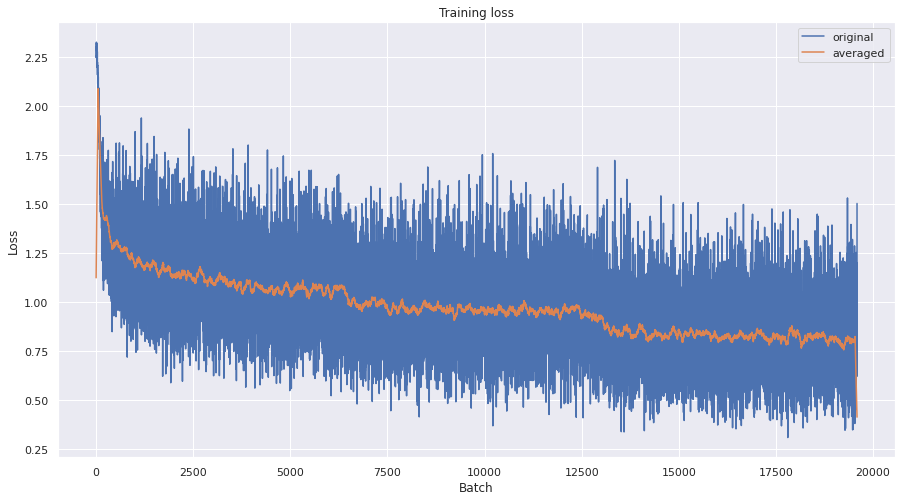

In [35]:
%matplotlib inline
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_lossv, label='original')
plt.plot(np.convolve(train_lossv, np.ones(101), 'same') / 101,
         label='averaged')
plt.legend(loc='best')
plt.show()

Evaluation

In [36]:
print('Test set:')
evaluate(test_dataloader)

Test set:
Accuracy: [38283/58029] 0.6597
Classification report:
              precision    recall  f1-score   support

     Country       0.63      0.09      0.15       388
  Electronic       0.29      0.01      0.02       444
        Folk       0.45      0.10      0.17      1691
     Hip-Hop       0.40      0.03      0.06       459
       Indie       0.19      0.02      0.04      1727
        Jazz       0.75      0.53      0.62      2702
       Metal       0.74      0.40      0.52      4034
         Pop       0.78      0.62      0.69     21789
         R&B       0.79      0.02      0.04       517
        Rock       0.60      0.88      0.71     24278

    accuracy                           0.66     58029
   macro avg       0.56      0.27      0.30     58029
weighted avg       0.66      0.66      0.63     58029

Confusion matrix:
[[   34     0    10     0     0     8     0    22     0   314]
 [    0     4     2     2     6     2    19   151     1   257]
 [    2     0   173     0    13  